In [0]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import plotly.express as px

In [0]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [0]:
data = pd.read_csv("/dbfs/FileStore/amazon_reviews_us_Mobile_Electronics_v1_00.csv", low_memory=False)
data.head()

Out[3]:

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefgÂ® FBI Covert Acoustic Tube Earpiece...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",31/08/2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data = data[['review_body','star_rating']]
data.dropna(inplace=True)
data['star_rating'] = data['star_rating'].astype(int)

In [0]:
### Over sampling to balance Dataset

In [0]:
data['star_rating'].value_counts()

Out[6]: 5 52198
4 18063
1 17572
3 9720
2 7298
Name: star_rating, dtype: int64

In [0]:
data['len'] = data['review_body'].apply(lambda s : len(s))

In [0]:
data  = data[data.len >1]

Out[9]:

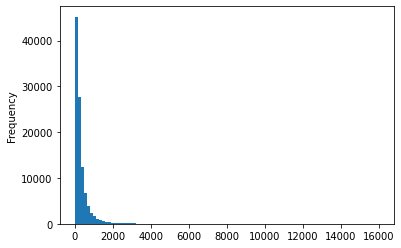

<AxesSubplot:ylabel='Frequency'>

In [0]:
data['len'].plot.hist(bins=100)

In [0]:
data.len.quantile(0.9)

Out[10]: 728.0

In [0]:
data.star_rating.value_counts()

Out[11]: 5 52186
4 18056
1 17572
3 9719
2 7298
Name: star_rating, dtype: int64

### Cleaning

In [0]:
import copy
df = copy.deepcopy(data)

In [0]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x
def remove_punctuation(x):
  new_string = re.sub(r'[^\w\s]', '', x)
  return new_string
  

In [0]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

Out[14]: 'this is a text with contraction'

In [0]:
# lower the text
df["review_body"] = df["review_body"].apply(lambda x: x.lower())

# Clean the text
df["review_body"] = df["review_body"].apply(lambda x: clean_text(x))

# Clean numbers
df["review_body"] = df["review_body"].apply(lambda x: clean_numbers(x))

# Clean Contractions
df["review_body"] = df["review_body"].apply(lambda x: replace_contractions(x))

df["review_body"] = df["review_body"].apply(lambda x: remove_punctuation(x))

In [0]:
count_df = df[['review_body','star_rating']].groupby('review_body').aggregate({'star_rating':'count'}).reset_index().sort_values('star_rating',ascending=False)
count_df.head(120)

Out[16]:

,review_body,star_rating
14751,good,277
98629,works great,218
16607,great,203
11513,excellent,162
18169,great product,132
...,...,...
93589,very nice product,5
100615,yes,5
19513,great value,5
52171,item delivered on time was as described,5


In [0]:
px.bar(count_df[count_df['star_rating']>4],x='review_body',y='star_rating')

Out[17]:

In [0]:
df['len'].max(),df['len'].min(), df['len'].mean()

Out[18]: (16009, 2, 342.49720025564955)

In [0]:
df['len'].describe()

Out[19]: count 104831.000000
mean 342.497200
std 526.515147
min 2.000000
25% 115.000000
50% 190.000000
75% 381.500000
max 16009.000000
Name: len, dtype: float64

Out[20]:

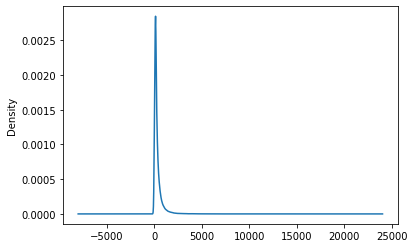

<AxesSubplot:ylabel='Density'>

In [0]:
df['len'].plot.kde()

In [0]:
df.drop("len",inplace = True, axis=1)

In [0]:
df.star_rating.value_counts()

Out[22]: 5 52186
4 18056
1 17572
3 9719
2 7298
Name: star_rating, dtype: int64

In [0]:
from sklearn.utils import resample

# separate data by labels
onestar = df[df.star_rating==1]
twostar = df[df.star_rating==2]
threestar = df[df.star_rating==3]
fourstar = df[df.star_rating==4]
fivestar = df[df.star_rating==5]

# upsample minority labels
onestar_upsampled = resample(onestar, replace=True, n_samples=len(fivestar), random_state=42)
twostar_upsampled = resample(twostar, replace=True, n_samples=len(fivestar), random_state=42)
threestar_upsampled = resample(threestar, replace=True, n_samples=len(fivestar), random_state=42)
fourstar_upsampled = resample(fourstar, replace=True, n_samples=len(fivestar), random_state=42)

# combine sets back together
data_sampled = pd.concat([onestar_upsampled, twostar_upsampled, threestar_upsampled, fourstar_upsampled, fivestar])
# check data is now balanced
data_sampled.star_rating.value_counts()

Out[23]: 1 52186
2 52186
3 52186
4 52186
5 52186
Name: star_rating, dtype: int64

In [0]:
df = copy.deepcopy(data_sampled)

In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df['review_body'], df['star_rating'],
                                                    stratify=df['star_rating'], 
                                                    test_size=0.25)

In [0]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape : (195697,)
Test shape : (65233,)

In [0]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [0]:
le.classes_

Out[29]: array([1, 2, 3, 4, 5])

In [0]:
dbutils.fs.mkdirs("/tmp/glove")

Out[30]: True

In [0]:
%sh
wget https://nlp.stanford.edu/data/glove.840B.300d.zip -P /dbfs/tmp/glove

--2022-04-09 17:18:46-- https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-04-09 17:18:47-- http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘/dbfs/tmp/glove/glove.840B.300d.zip.1’

 0K .......... .......... .......... .......... .......... 0% 253K 2h19m
 50K .......... .......... .......... .......... .......... 0% 353K 2h0m
 100K .......... .......... .......... .......... .......... 0% 1.06M 90m57s
 150K .......... .......... .......... .......... .......... 0% 453K 87m46s
 200K .......... .......... .......... .......... .......... 0% 3.98M 71m57s
 250K .......... .......... .......... .......... .......... 0% 411K 74m19s
 300K .......... .......... .......... .......... .......... 0% 2.06M 66m6s
 350K .......... .......... .......... .......... .......... 0% 6.20M 58m32s
 400K .......... .......... .......... .......... .......... 0% 21.7M 52m12s
 450K .......... .......... .......... .......... .......... 0% 6.18M 47m33s
 500K .......... .......... .......... .......... .......... 0% 457K 50m16s
 550K .......... .......... .......... .......... .......... 0% 3.27M 46m58s
 600K .......... .......... .......... .......... .......... 0% 6.20M 43m47s
 650K .......... .......... .......... .......... .......... 0% 13.6M 40m50s
 700K .......... .......... .......... .......... .......... 0% 30.9M 38m11s
 750K .......... .......... .......... .......... .......... 0% 33.5M 35m52s
 800K .......... .......... .......... .......... .......... 0% 32.6M 33m49s
 850K .......... .......... .......... .......... .......... 0% 15.8M 32m3s
 900K .......... .......... .......... .......... .......... 0% 27.4M 30m26s
 950K .......... .......... .......... .......... .......... 0% 509K 32m23s
 1000K .......... .......... .......... .......... .......... 0% 6.48M 31m6s
 1050K .......... .......... .......... .......... .......... 0% 6.68M 29m55s
 1100K .......... .......... .......... .......... .......... 0% 6.31M 28m51s
 1150K .......... .......... .......... .......... .......... 0% 7.83M 27m50s
 1200K .......... .......... .......... .......... .......... 0% 15.3M 26m49s
 1250K .......... .......... .......... .......... .......... 0% 30.3M 25m49s
 1300K .......... .......... .......... .......... .......... 0% 26.8M 24m55s
 1350K .......... .......... .......... .......... .......... 0% 32.1M 24m4s
 1400K .......... .......... .......... .......... .......... 0% 30.7M 23m16s
 1450K .......... .......... .......... .......... .......... 0% 29.7M 22m32s
 1500K .......... .......... .......... .......... .......... 0% 25.9M 21m51s
 1550K .......... .......... .......... .......... .......... 0% 27.4M 21m12s
 1600K .......... .......... .......... .......... .......... 0% 30.5M 20m36s
 1650K .......... .......... .......... .......... .......... 0% 26.4M 20m2s
 1700K .......... .......... .......... .......... .......... 0% 26.5M 19m30s
 1750K .......... .......... .......... .......... .......... 0% 32.8M 18m59s
 1800K .......... .......... .......... .......... .......... 0% 32.9M 18m30s
 1850K .......... .......... .......... .......... .......... 0% 564K 19m40s
 1900K .......... .......... .......... .......... .......... 0% 10.5M 19m15s
 1950K .......... .......... .......... .......... .......... 0% 12.8M 18m50s
 2000K .......... .......... .......... .......... .......... 0% 12.8M 18m26s
 2050K .......... .......... .......... .......... .......... 0% 1

In [0]:
dbutils.fs.ls("/tmp/glove")

Out[32]: [FileInfo(path='dbfs:/tmp/glove/download', name='download', size=6587),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.txt', name='glove.840B.300d.txt', size=5646236541),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip', name='glove.840B.300d.zip', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.1', name='glove.840B.300d.zip.1', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/models/', name='models/', size=0)]

In [0]:
import zipfile
# EXTRACT if Necessary
# Unzip and extract in file. Maybe, could be better to unzip in memory with StringIO.
with zipfile.ZipFile('/dbfs/tmp/glove/glove.840B.300d.zip', 'r') as zip_ref:
    zip_ref.extractall('/dbfs/tmp/glove/')

In [0]:
dbutils.fs.ls("/tmp/glove")

Out[34]: [FileInfo(path='dbfs:/tmp/glove/download', name='download', size=6587),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.txt', name='glove.840B.300d.txt', size=5646236541),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip', name='glove.840B.300d.zip', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/glove.840B.300d.zip.1', name='glove.840B.300d.zip.1', size=2176768927),
 FileInfo(path='dbfs:/tmp/glove/models/', name='models/', size=0)]

In [0]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = '/dbfs/tmp/glove/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [0]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/databricks/python/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

In [0]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [0]:
n_epochs = 20
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<command-241534>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

Epoch 1/20 loss=596.4397 val_loss=515.7928 val_acc=0.5755 time=152.24s
Epoch 2/20 loss=490.7367 val_loss=461.0382 val_acc=0.6359 time=161.65s
Epoch 3/20 loss=430.1489 val_loss=406.6558 val_acc=0.6908 time=161.83s
Epoch 4/20 loss=383.4416 val_loss=369.8621 val_acc=0.7264 time=162.79s
Epoch 5/20 loss=348.4224 val_loss=336.7896 val_acc=0.7530 time=161.43s
Epoch 6/20 loss=320.3503 val_loss=315.4732 val_acc=0.7734 time=160.95s
Epoch 7/20 loss=299.1353 val_loss=295.2615 val_acc=0.7904 time=161.01s
Epoch 8/20 loss=280.7748 val_loss=285.9260 val_acc=0.7952 time=160.66s
Epoch 9/20 loss=267.2628 val_loss=270.9959 val_acc=0.8085 time=160.88s
Epoch 10/20 loss=254.4529 val_loss=261.1858 val_acc=0.8143 time=161.21s
Epoch 11/20 loss=243.8827 val_loss=253.4044 val_acc=0.8200 time=162.39s
Epoch 12/20 loss=235.7342 val_loss=249.3268 val_acc=0.8243 time=161.22s
Epoch 13/20 loss=226.7463 val_loss=237.5348 val_acc=0.8338 time=162.39s
Epoch 14/20 loss=221.1302 val_loss=234.2655 val_acc=0.8358 time=162.21s
Epoch 15/20 loss=213.7214 val_loss=231.3820 val_acc=0.8399 time=161.46s
Epoch 16/20 loss=208.8605 val_loss=230.0421 val_acc=0.8389 time=162.95s
Epoch 17/20 loss=203.6600 val_loss=221.1926 val_acc=0.8463 time=163.98s
Epoch 18/20 loss=199.2544 val_loss=223.4778 val_acc=0.8469 time=163.78s
Epoch 19/20 loss=194.3148 val_loss=215.6584 val_acc=0.8546 time=163.53s
Epoch 20/20 loss=190.0668 val_loss=219.4935 val_acc=0.8519 time=162.99s

In [0]:
dbutils.fs.mkdirs("/tmp/glove/models")

Out[51]: True

In [0]:
torch.save(model,'/dbfs/tmp/glove/models/textcnn_model_glove')

In [0]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

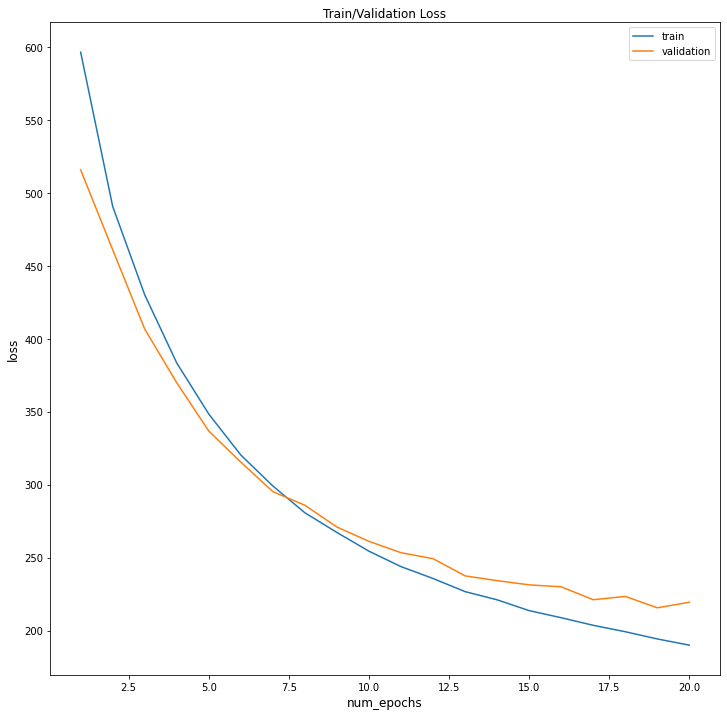

In [0]:
plot_graph(n_epochs)

Out[55]:

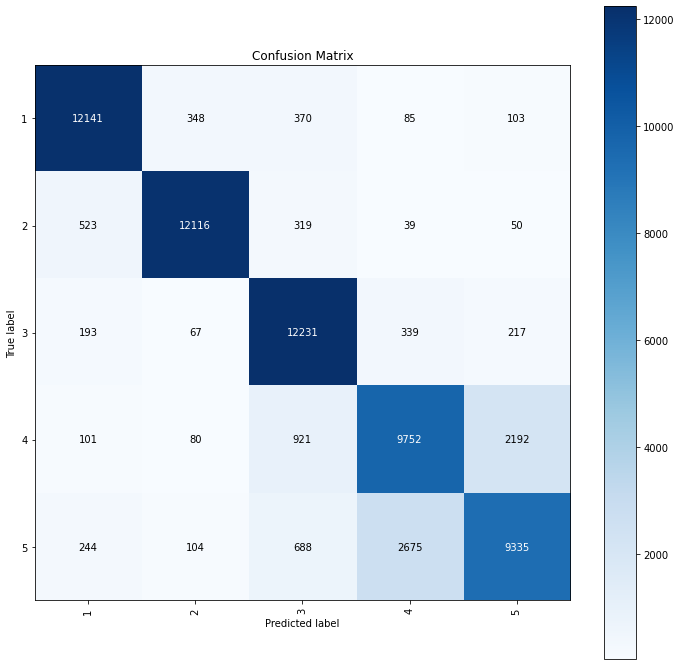

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

In [0]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [0]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [0]:
n_epochs = 20
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

<command-241541>:48: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

Epoch 1/20 loss=627.0122 val_loss=544.8769 val_acc=0.5302 time=88.32s
Epoch 2/20 loss=522.8968 val_loss=494.7609 val_acc=0.5758 time=88.38s
Epoch 3/20 loss=478.9558 val_loss=464.3841 val_acc=0.6080 time=87.12s
Epoch 4/20 loss=434.4098 val_loss=435.3991 val_acc=0.6425 time=87.41s
Epoch 5/20 loss=389.2329 val_loss=426.7794 val_acc=0.6509 time=88.54s
Epoch 6/20 loss=346.3888 val_loss=374.9777 val_acc=0.7094 time=87.43s
Epoch 7/20 loss=304.1625 val_loss=332.6226 val_acc=0.7531 time=88.75s
Epoch 8/20 loss=269.1803 val_loss=296.9352 val_acc=0.7865 time=87.34s
Epoch 9/20 loss=237.6341 val_loss=283.6864 val_acc=0.7969 time=88.37s
Epoch 10/20 loss=211.7010 val_loss=259.5039 val_acc=0.8177 time=88.20s
Epoch 11/20 loss=188.4854 val_loss=251.2787 val_acc=0.8291 time=87.67s
Epoch 12/20 loss=171.3803 val_loss=237.3465 val_acc=0.8369 time=89.25s
Epoch 13/20 loss=157.6207 val_loss=228.5628 val_acc=0.8470 time=88.59s
Epoch 14/20 loss=143.0988 val_loss=209.4859 val_acc=0.8608 time=88.26s
Epoch 15/20 loss=132.5498 val_loss=207.9527 val_acc=0.8648 time=88.49s
Epoch 16/20 loss=123.7151 val_loss=216.6261 val_acc=0.8613 time=88.80s
Epoch 17/20 loss=124.3995 val_loss=240.8472 val_acc=0.8521 time=88.99s
Epoch 18/20 loss=105.4340 val_loss=245.2376 val_acc=0.8520 time=88.78s
Epoch 19/20 loss=101.6092 val_loss=200.1681 val_acc=0.8827 time=88.70s
Epoch 20/20 loss=96.4088 val_loss=215.6955 val_acc=0.8738 time=88.94s

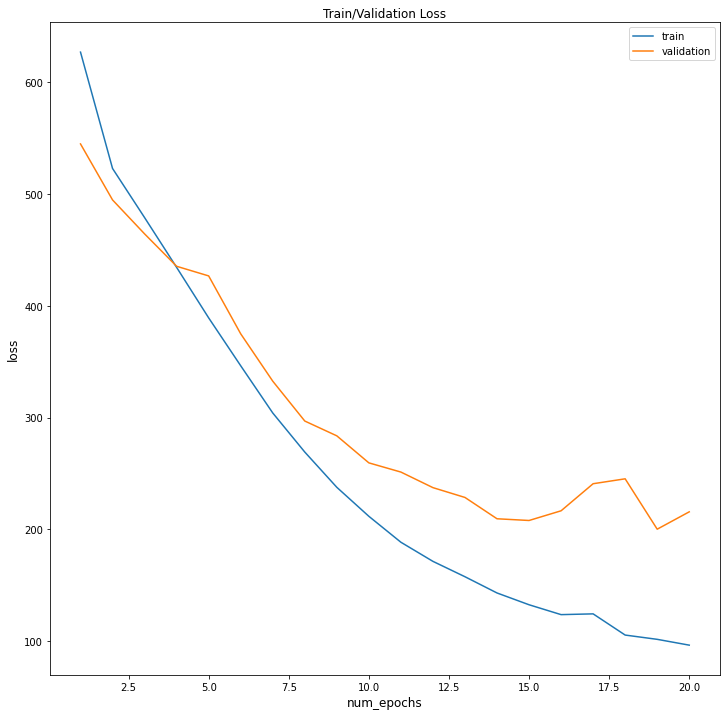

In [0]:
plot_graph(n_epochs)

In [0]:
torch.save(model,'/dbfs/tmp/glove/models/bilstm_model_glove')

Out[60]:

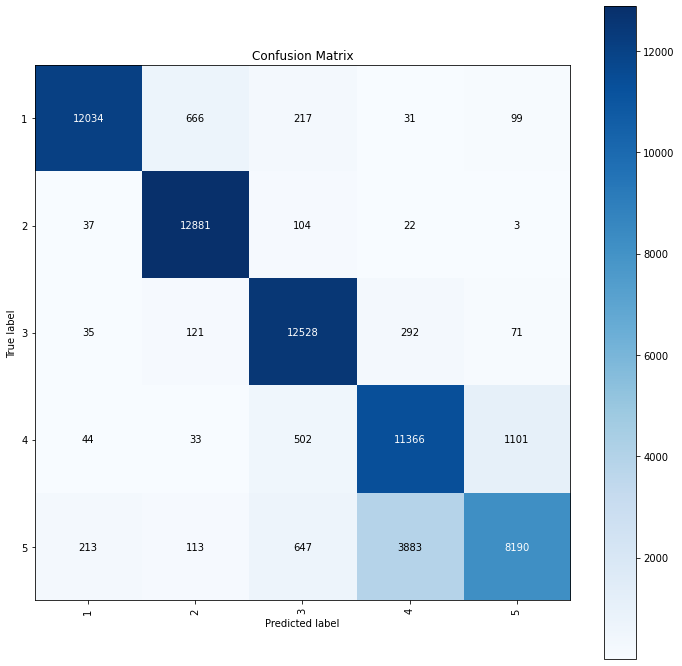

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

In [0]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)